<a href="https://colab.research.google.com/github/LarsHadidi/PRONTO/blob/mathprogram/PDP-CSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progressive Dinner Party: Constraint Satisfaction Program

## Hosted Runtime

In [1]:
!mkdir /opt/minizinc
!wget -q https://github.com/MiniZinc/MiniZincIDE/releases/download/2.6.4/MiniZincIDE-2.6.4-bundle-linux-x86_64.tgz -P /opt/minizinc
!tar -xf /opt/minizinc/MiniZincIDE-2.6.4-bundle-linux-x86_64.tgz -C /opt/minizinc
!mv /opt/minizinc/MiniZincIDE-2.6.4-bundle-linux-x86_64/* /opt/minizinc
!cp /opt/minizinc/bin/minizinc /bin
!cp -R /opt/minizinc/share/* /usr/local/share
%env MZN_STDLIB_DIR=/opt/minizinc/share/minizinc
%env LD_LIBRARY_PATH=/opt/minizinc/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

env: MZN_STDLIB_DIR=/opt/minizinc/share/minizinc
env: LD_LIBRARY_PATH=/opt/minizinc/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


In [8]:
!pip install -q iminizinc
%load_ext iminizinc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.6.4, build 570825159
Copyright (C) 2014-2022 Monash University, NICTA, Data61


## Local Runtime

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0`

## Imports

In [2]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import ipywidgets as widgets
import matplotlib.pyplot as plt

## Formulation

\begin{array}{|c|c|}
\hline
N := \{1,..,n\}&  \text{Set of integers from one to $n$}  \\[1em] 
\hline
t_{ij} \in \mathbb{N}^{3\times N}&  \text{Element of $j^{th}$ tour, where
$t_{1j}$=starters node, $t_{2j}$=main node, $t_{3j}$=desert node}  \\[1em] 
\hline
t^{i[J]}:=\{t_{ij}|j=J\},\hspace{1em}t^{[I]j}:=\{t_{ij}|i=I\}&  \text{Set of all $t_{ij}$ where one of the indices is fixed}  \\[1em] 
\hline
\end{array}

\begin{array}{|l|c|c|c|}
\hline
\textbf{Constraint} & \textbf{Meaning} & \textbf{Count} \\[2em]
\hline
∀ j:\hspace{1em} t_{1j}\neq t_{2j}\neq t_{3j} & \text{Each course at a different location} & N \\[2em]
\hline
∀ i:\hspace{1em}∀ r \in t^{[iN]}:\hspace{1em} \left|\{x\in t^{[iN]}|x=r\}\right|=3& \text{Three tours intersect at each course} & 3N \\[2em]
\hline
t^{[1N]}\cap t^{[2N]}\cap t^{[3N]} = \varnothing& \text{Each location hosts one course} & 1 \\[2em]
\hline
∀ p\in N, q\in N, q<p:\hspace{1em} \left|t^{i[p]} \cap t^{i[q]}\right| \leq 1& \text{Two tours intersect at most once} & N^2-N \\[2em]
\hline
\end{array}

# Data

In [5]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=1, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=1, description='Clusters'), FloatText(value=…

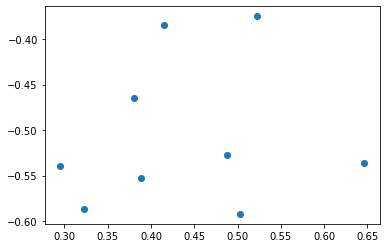

In [6]:
rng = np.random.default_rng()

n = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert n >= 9
assert K > 0
assert n % K == 0
assert n % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (n // K, 2))

X = np.array(list(points.values())).reshape(n, 2)[:,0]
Y = np.array(list(points.values())).reshape(n, 2)[:,1]

G = nx.DiGraph()
for i in range(n):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((n,n))
for a,b in itertools.product(range(n), range(n)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

plt.scatter(X,Y)
plt.show()

## Implementation

In [9]:
%%minizinc -m bind

include "alldifferent.mzn";
include "all_disjoint.mzn";
include "count.mzn";

int: n;
set of int: N = 1..n;

array[1..3,N] of var N: t;

predicate soft_disjoint_columns (var set of $$T: p, var set of $$T: q, int: m) = card(p intersect q) <= m;

constraint all_disjoint([array2set(t[i,N]) | i in 1..3]);
constraint forall (j in N) (alldifferent(t[1..3, j])) :: "once_per_column";
constraint forall (i in 1..3, x in t[i,N]) (count(t[i,N], x) = 3) :: "three_per_row";
constraint forall (p in N, q in 1..(p - 1)) (soft_disjoint_columns( array2set(t[1..3,p]), array2set(t[1..3,q]), 1 )) :: "limit_encounters";

solve satisfy;

In [10]:
pd.DataFrame(t)

,0,1,2,3,4,5,6,7,8
0,5,3,8,5,3,8,8,3,5
1,7,4,2,4,2,7,4,7,2
2,9,9,9,6,6,6,1,1,1


In [11]:
def objective(𝚷: list, T: np.array, C: np.array):
  N = len(C)
  
  S = T[0,:]
  M = T[1,:]
  D = T[2,:]

  p_S = [𝚷[T[0,i]-1] for i in range(N)]
  p_M = [𝚷[T[1,i]-1] for i in range(N)]
  p_D = [𝚷[T[2,i]-1] for i in range(N)]

  return sum([C[p_S[i],p_M[i]] + C[p_M[i],p_D[i]] for i in range(N)])

In [12]:
T = np.array(t)
print(f'Current objective value: {objective(list(range(n)), T, C)}')

Current objective value: 3.221190966533359


In [13]:
!pip install -q simanneal
from simanneal import Annealer

In [14]:
class Permutation(Annealer):
  def __init__(self, state: list, C: np.array, T: np.array):
    self.C = C
    self.T = T
    super(Permutation, self).__init__(state)
  
  def move(self):
    a = np.random.randint(0, len(self.state) - 1)
    b = np.random.randint(0, len(self.state) - 1)
    self.state[a], self.state[b] = self.state[b], self.state[a]
  
  def energy(self):
    energy = objective(self.state, T, C)
    return energy

In [15]:
permutation = Permutation(list(range(n)), C, T)

In [16]:
permutation.Tmax = 1e5
permutation.Tmin = 0.1
permutation.steps = 1e5

In [17]:
𝚷, y = permutation.anneal()
print(f'Annealed objective value: {y}')

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Annealed objective value: 2.805445927722539


## Results

In [19]:
def draw_graph(nodes: dict, edges: list[tuple]):
	G = nx.DiGraph()
	G.add_nodes_from(nodes)
	G.add_edges_from(edges)
	pos = {k: list(v.values()) for k, v in nodes.items()}
	edge_colors = nx.get_edge_attributes(G,'color').values()
	node_colors = np.array(list(dict(G.in_degree(G.nodes)).values())) - np.array(list(dict(G.out_degree(G.nodes)).values()))
  

	nx.draw(
			G, pos,
			edge_color = edge_colors,
			edge_cmap = plt.cm.get_cmap('Set3'),
			node_color = node_colors,
			width=3, node_size=50, connectionstyle='arc3,rad=0.1')
	plt.show()

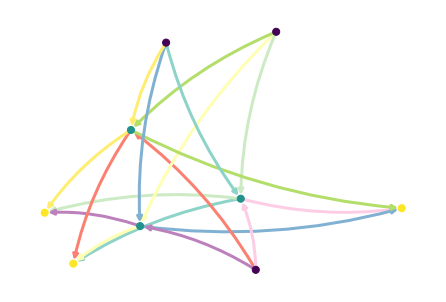

In [23]:
nodes = dict(G.nodes(data=True))
edges = []
for m in range(n):
    edges.append((𝚷[T[0,m]-1], 𝚷[T[1,m]-1], {'color':m}))
    edges.append((𝚷[T[1,m]-1], 𝚷[T[2,m]-1], {'color':m}))
node_colors = np.array(list(dict(G.in_degree(G.nodes)).values()))-np.array(list(dict(G.out_degree(G.nodes)).values()))
draw_graph(nodes, edges)